# Obspy 

https://docs.obspy.org/tutorial/

地震處理資料的軟體包,沒有hand_pick的套件


In [1]:
from obspy import UTCDateTime 
from obspy import read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
from obspy.taup import TauPyModel
from obspy.io.sac import attach_paz

## 1. UTCDateTime 

#### Handling Time - The **`UTCDateTime`** Class

 - All absolute time values are consistently handled with this class
 - No need to worry about timezones (can be specified at initialization, internally)
 - Based on a high precision POSIX timestamp and not the Python datetime class because precision was an issue

In [2]:
### 現在時間 UTC
UTCDateTime()

2020-07-06T07:56:01.395511Z

In [3]:
### 現在台灣時間UTC+8小時
timenow = UTCDateTime()+8*60*60
print(timenow)

2020-07-06T15:56:23.365514Z


In [4]:
print(timenow.year)
print(timenow.julday)
print(timenow.timestamp)
print(timenow.weekday)
print(timenow.date)
print(timenow.format_iris_web_service())

2020
188
1594050983.365514
0
2020-07-06
2020-07-06T15:56:23.365


In [5]:
UTCDateTime("2019-11-18 21:26:26")

2019-11-18T21:26:26.000000Z

In [6]:
UTCDateTime("2019/11/18 21:26:26")

2019-11-18T21:26:26.000000Z

In [7]:
a=UTCDateTime("2018-322 21:26:26")
b=UTCDateTime("2018-323 21:26:26")
a<b

True

In [8]:
UTCDateTime(year=2019, julday=213, hour=14, minute=13)

2019-08-01T14:13:00.000000Z

In [9]:
UTCDateTime("2019/06/26 03")

2019-06-26T03:00:00.000000Z

## 2. read the file 

read () 支援大部分的地震檔案格式，mseed,sac...etc.

* Stream : 像是裝著sac file的資料夾，read ()讀進來之後都是這種格式，常簡寫為st，使用方式與list很像。


* Trace：就是一般的sac file,取用方式是透過stream,stream[0]代表stream中的第一個trace

<img src="images/Stream_Trace.svg" width="800" >

In [ ]:
from obspy import read
miniseed=' ' ### 你的miniseed檔名
st=read(miniseed) ### 讀進來是stream
st[0] ### stream[0]=Trace, 寫法很像list

## 2.1 stream的擴增

st = read (file 1 )

st += read( file 2 )

In [ ]:
st=read(sacf)
n_file=str(sacf).replace("HHZ","HHN") ; e_file=str(sacf).replace("HHZ","HHE")

st+=read(glob.glob(n_file)[0])
st+=read(glob.glob(e_file)[0])

# 3. get event list and waveforms from IRIS 

#### obspy.clients.fdsn - FDSN web service client for ObsPy

The International Federation of Digital Seismograph Networks (FDSN) 

**from obspy.clients.fdsn import Client**

**client = Client("IRIS")**

* client.get_events : 拿到catalog，裡面會包含event的資訊

* client.get_wavefroms : 拿到wavefrom

* client.get_stations : 拿到測站的資訊



## 3.1 `get_events` : 拿到catalog

包含event的資訊

In [10]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime 

### event location research range
locationDic={"minlat":-12,"maxlat":-5,"minlon":153,"maxlon":167}

### get the event
eveTime=UTCDateTime("2019/06/26 03") ### or UTCDateTime("2019062603")

client = Client("IRIS")
Cata = client.get_events(starttime=eveTime, endtime=eveTime+3600,
                         minlatitude=locationDic['minlat'],maxlatitude=locationDic['maxlat'],
                         minlongitude=locationDic['minlon'], maxlongitude=locationDic['maxlon'],
                         minmag=5,catalog="NEIC PDE")

print(Cata)

1 Event(s) in Catalog:
2019-06-26T03:18:15.324000Z |  -9.536, +157.747 | 5.7 Mww


####  Classes for handling event metadata
https://docs.obspy.org/master/packages/obspy.core.event.html

地震目錄架構 (obspy的邏輯)
<img src="images/eventmeta_obspy.png" width="800">

In [4]:
Cata[0]

Event:	2019-06-26T03:18:15.324000Z |  -9.536, +157.747 | 5.7 Mww

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=11053280")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=39228037")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=193667299")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements

In [5]:
Cata[0].origins[0]

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=39228037")
	          time: UTCDateTime(2019, 6, 26, 3, 18, 15, 324000)
	     longitude: 157.7469
	      latitude: -9.536
	         depth: 12440.0
	 creation_info: CreationInfo(author='us')

In [4]:
EVLA=Cata[0].origins[0].latitude
EVLO=Cata[0].origins[0].longitude
EVDP=Cata[0].origins[0].depth/1000
print(EVLA,EVLO,EVDP)

-9.536 157.7469 12.44


In [11]:
###發震時間
EVTtime=Cata[0].origins[0].time
print(EVTtime)

2019-06-26T03:18:15.324000Z


## 3.2  `get_stations` 拿到測站的基本資料(經度 緯度 az... etc) 

* Station Metadata (inventory)


<img src="images/obs_station.png" width="800" >

In [14]:
### level='channel' channel的資料要最詳細，如果要轉成RTZ就需要！
inventory = client.get_stations(network="IU", station="HNR",location="00",channel="BH*",level="channel")

In [15]:
inventory

Inventory created at 2020-07-06T08:03:53.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?network=IU&station=H...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (3):
			IU.HNR (Honiara, Solomon Islands) (3x)
		Channels (30):
			IU.HNR.00.BHZ (10x), IU.HNR.00.BHN, IU.HNR.00.BHE, 
			IU.HNR.00.BH1 (9x), IU.HNR.00.BH2 (9x)

In [16]:
STLA = inventory[0].stations[0].latitude
STLO = inventory[0].stations[0].longitude
print(STLA, STLO)

-9.4387 159.9475


## 3.3  `get_waveforms` : 拿到波形
* read waveform data is returned as a **`Stream`** object.

`obspy.clients.fdsn.client.Client.get_waveforms`

Client.get_waveforms(network, station, location, channel, starttime, endtime, quality=None, minimumlength=None, longestonly=None, filename=None, attach_response=False, **kwargs)[source]

In [17]:
st = client.get_waveforms(network="IU", station="HNR",
                          location="00", channel="BH?",
                          starttime=EVTtime,
                          endtime=EVTtime + 600,attach_response=True)
#attach_response 要儀器響應

In [18]:
print(st)

3 Trace(s) in Stream:
IU.HNR.00.BH1 | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BH2 | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples


In [13]:
### 查看st中第一個trace的資料，trace才有stats，st[0]的[0]很容易忘記寫。
st[0].stats

               network: IU
               station: HNR
              location: 00
               channel: BH1
             starttime: 2019-06-26T03:18:15.344538Z
               endtime: 2019-06-26T03:28:15.319538Z
         sampling_rate: 40.0
                 delta: 0.025
                  npts: 24000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 119, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 178176})
            processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2019, 6, 26, 3, 28, 15, 319538)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 6, 26, 3, 18, 15, 319538))']
              response: Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.82872e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosR

In [19]:
for tr in st:
    print(tr)
    print(tr.stats.channel)

IU.HNR.00.BH1 | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
BH1
IU.HNR.00.BH2 | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
BH2
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
BHZ


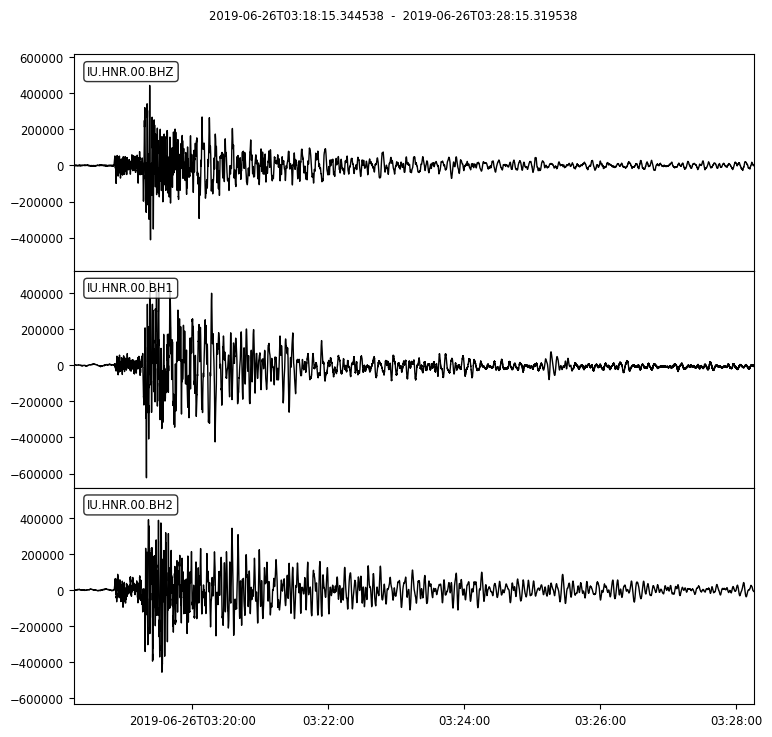

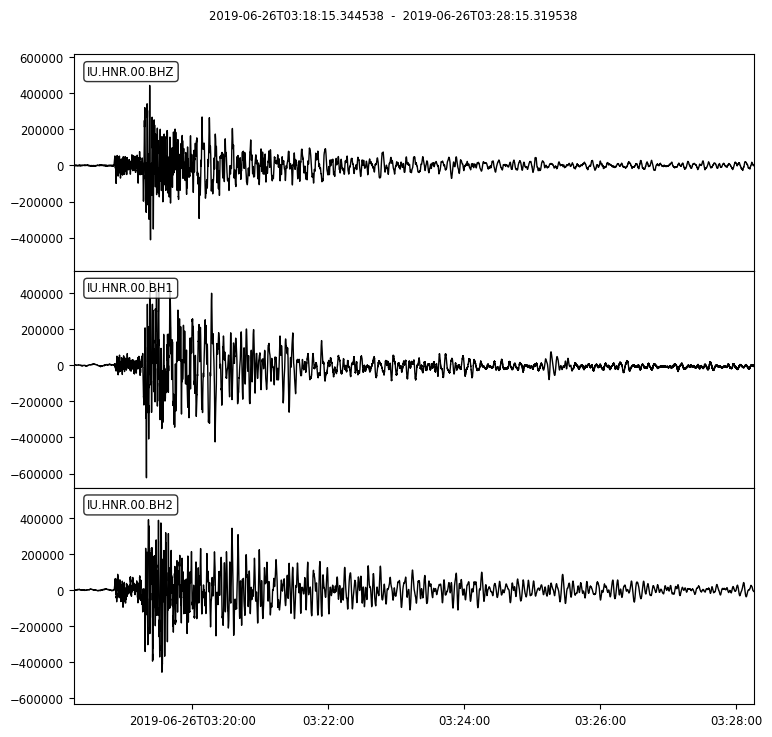

In [21]:
### 畫圖
st.plot()

### 3.3.1 Quick  plot 

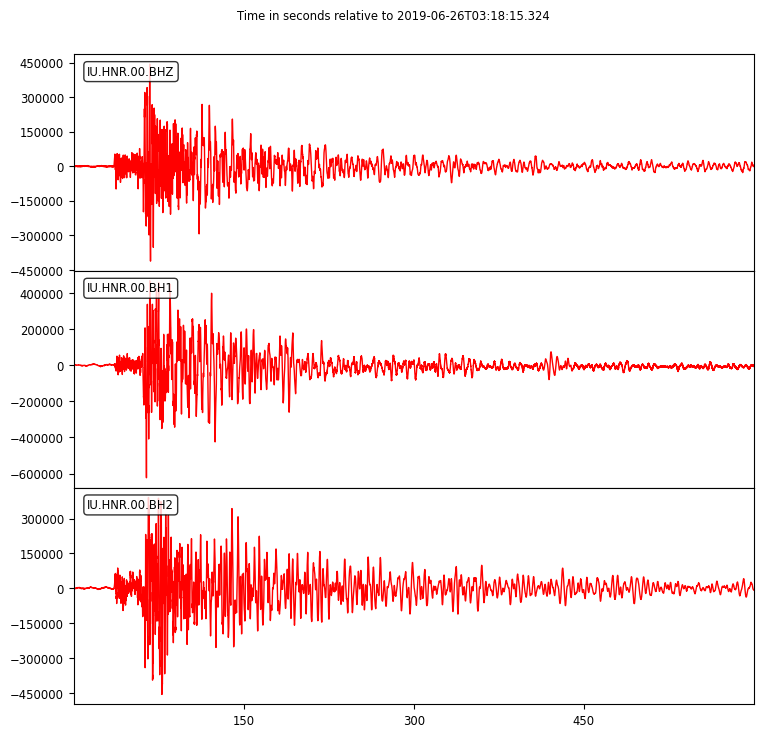

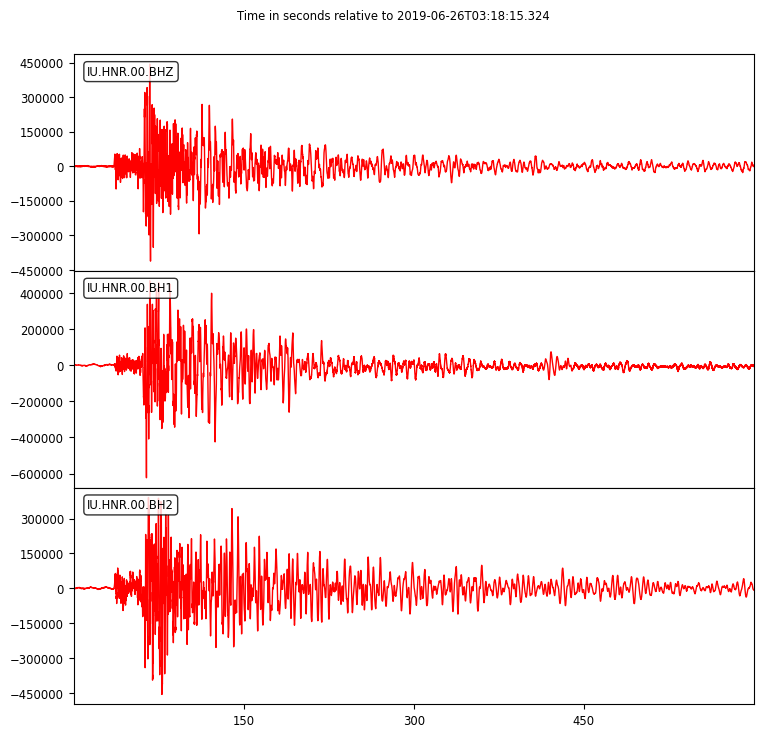

In [22]:
### 相對時間畫圖
st.plot(color='red',type='relative',reftime=EVTtime, equal_scale = False)

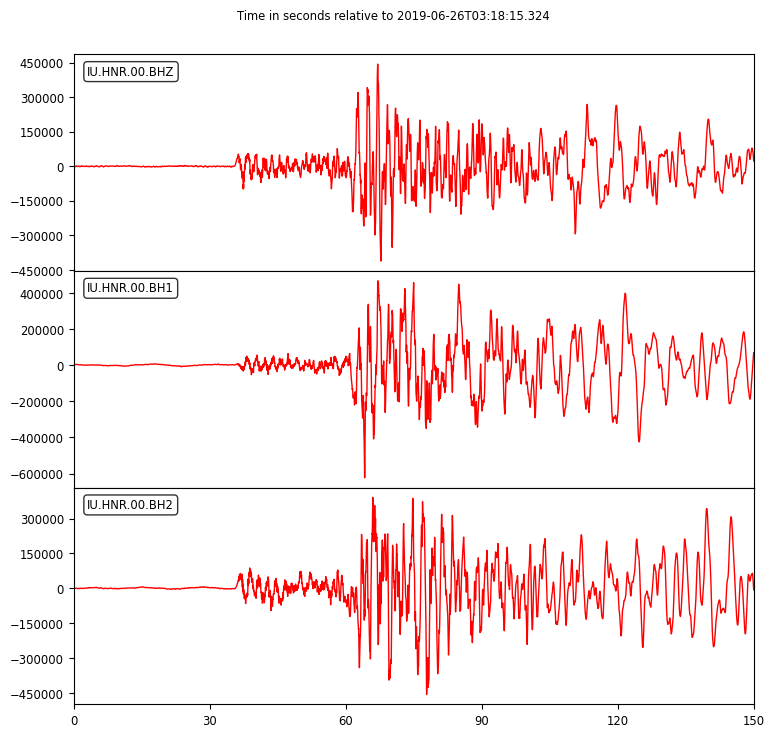

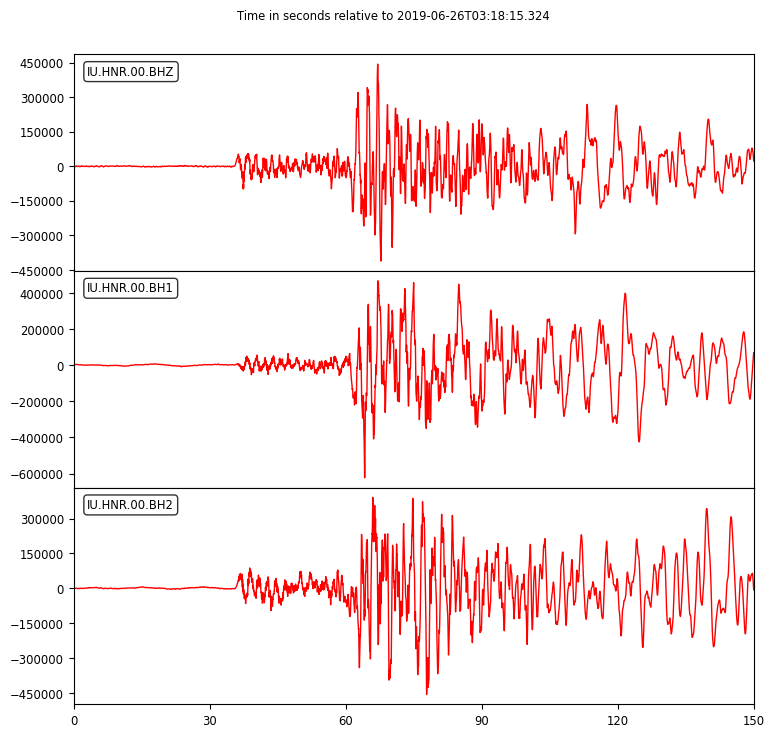

In [23]:
### xlim 0-150
st.plot(color='red',type='relative',reftime=EVTtime,starttime=EVTtime, 
        endtime=EVTtime+150, equal_scale = False)

In [23]:
### 輸出成pdf
st.plot(outfile='./test.pdf',color='red',type='relative',reftime=EVTtime,starttime=EVTtime, 
        endtime=EVTtime+150, equal_scale = False)

### 3.3.2 with matplotlib

(0.0, 150.0)

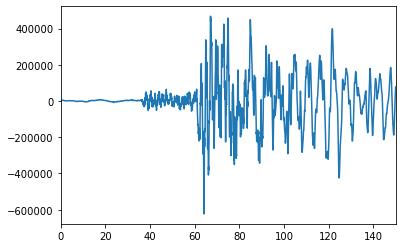

In [27]:
import matplotlib.pyplot as plt
plt.plot(st[0].times(),st[0].data)
plt.xlim([0,150])

### 4. output to sac 

In [24]:
### 輸出成sac
for tr in st: 
    print(tr.id)
    tr.write(tr.id + ".sac", format="SAC") 

IU.HNR.00.BH1
IU.HNR.00.BH2
IU.HNR.00.BHZ


## 5 azimuth and distance 

In [11]:
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
gcarcinfo = gps2dist_azimuth(STLA,STLO,EVLA, EVLO) ### 順序不能動


gcarc = kilometers2degrees(gcarcinfo[0]/1000)
dist=gcarcinfo[0]/1000
baz=gcarcinfo[1]
az=gcarcinfo[2]


## 6 Predict arrival time and ray path

https://docs.obspy.org/packages/obspy.taup.html

* Models can be initialized by specifying the name of a model provided by ObsPy.

* obspy.taup.tau.TauPy.Model.get_travel_times

In [12]:
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
parrival = model.get_travel_times(source_depth_in_km=EVDP,
                                  distance_in_degree=float(gcarc),
                                  phase_list=['p','P'])

print(parrival[0].time)
print(parrival[0].name)

35.9446822252
P


In [13]:
print(parrival)

5 arrivals
	P phase arrival at 35.945 seconds
	P phase arrival at 39.250 seconds
	P phase arrival at 39.582 seconds
	p phase arrival at 41.715 seconds
	P phase arrival at 41.896 seconds


## 5.  資料前處理 data_processing

# 資料處理前一定要copy( )

##### 非常重要，obspy會直接更改原始的miniseed檔

stf=st.copy() 

##### 非常重要，obspy會直接更改原始的miniseed檔

sac command:

rotate

rmean

rtr

taper 

trans from polezero s xxx.pz to none freq 0.02 0.05 18 20

bp,hp,lp(filter)

## 5.0 copy

In [14]:
stf=st.copy()

## 5.1 rotate

In [15]:
stf=stf.rotate(method="->ZNE",inventory=inventory)

In [16]:
stf=stf.rotate(method="NE->RT",back_azimuth=baz)

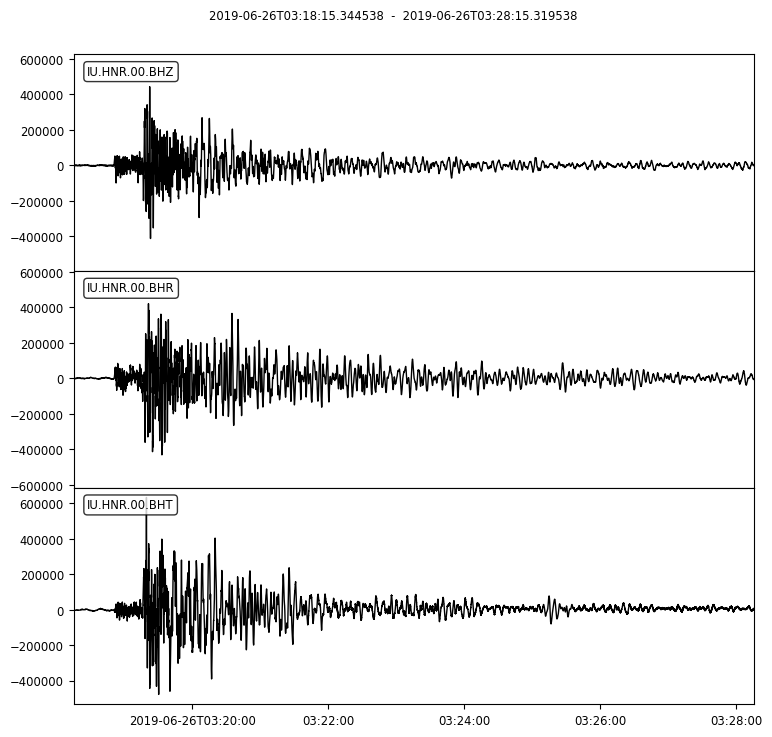

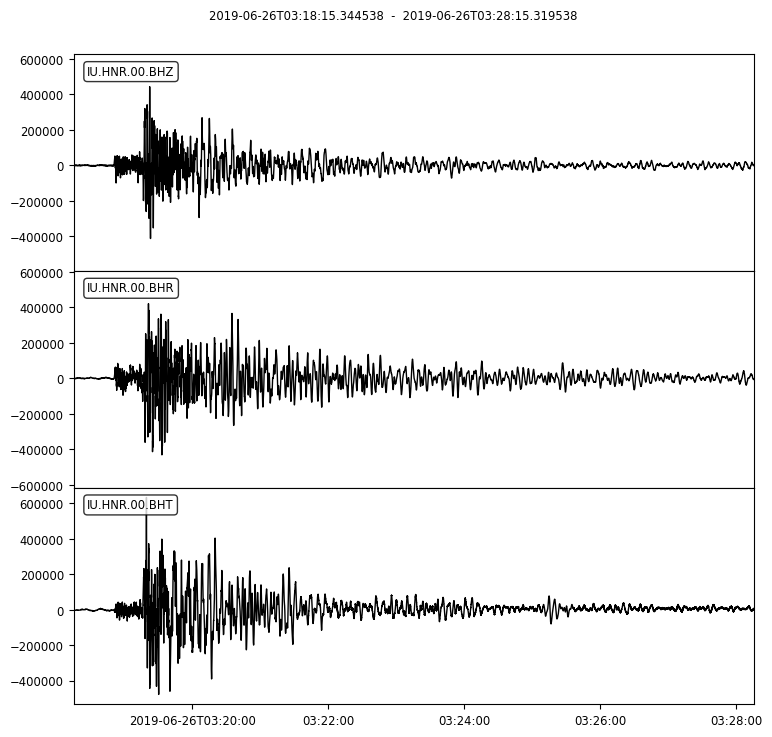

In [27]:
stf.plot()

## 5.2 rmean;rtr

In [28]:
stf.detrend(type='demean')
stf.detrend(type='linear')

3 Trace(s) in Stream:
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHR | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHT | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples

## 5.3 taper

In [29]:
stf.taper(0.05, type='hann')

3 Trace(s) in Stream:
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHR | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHT | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples

## 5.4 Remove Instrument Response

In [30]:
nqf=stf[0].stats.sampling_rate/2 ###nyquist frequency
pre_filt = [0.005, 0.008 , nqf-2, nqf] ### zero phase filter band
stf.remove_response(pre_filt=pre_filt,output='disp') ### 會自動把stf更新
stf.taper(0.05, type='hann')

3 Trace(s) in Stream:
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHR | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHT | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples

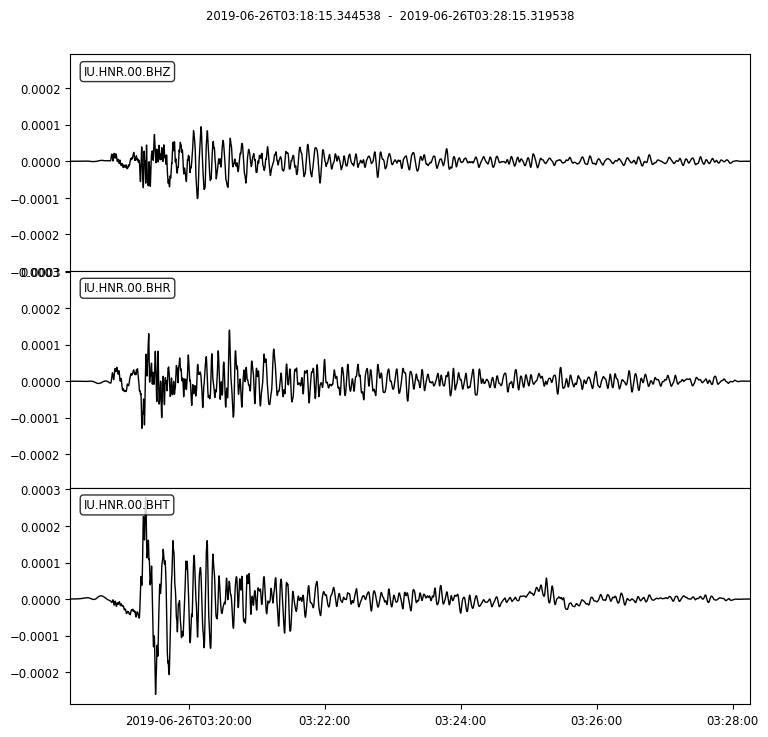

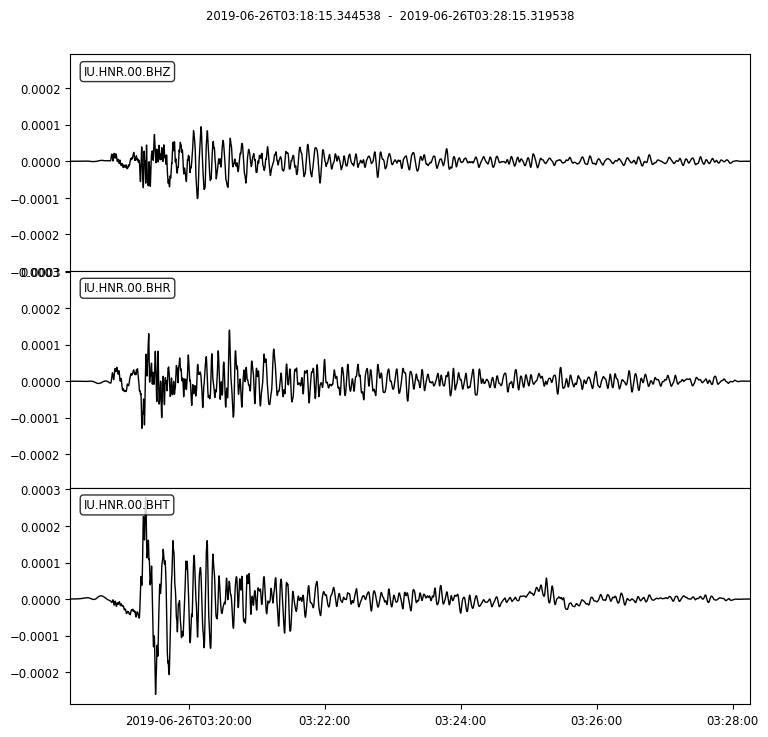

In [31]:
stf.plot()

### 5.4.1  PZ file 

In [ ]:
from obspy.io.sac import attach_paz
### 把PZ的資料餵給stf中的每個檔案
for i in range(len(stf)):
    attach_paz(stf[i],PZ)

paz = dict(stf[0].stats.paz) ### 從第一個檔案中拿出PZ資料
stf.simulate(paz_remove=paz,pre_filt=pre_filt)

stf.taper(0.05, type='hann')

## 5.5 filter 

預設 corners=4

filter type : highpass , lowpass, bandpass


stf.filter("bandpass", freqmin=,freqmax= ,corners=4, zerophase=False)

In [32]:
stf2=stf.copy()
stf.filter("bandpass", freqmin=0.1,freqmax=2,corners=3, zerophase=False)

3 Trace(s) in Stream:
IU.HNR.00.BHZ | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHR | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples
IU.HNR.00.BHT | 2019-06-26T03:18:15.344538Z - 2019-06-26T03:28:15.319538Z | 40.0 Hz, 24000 samples

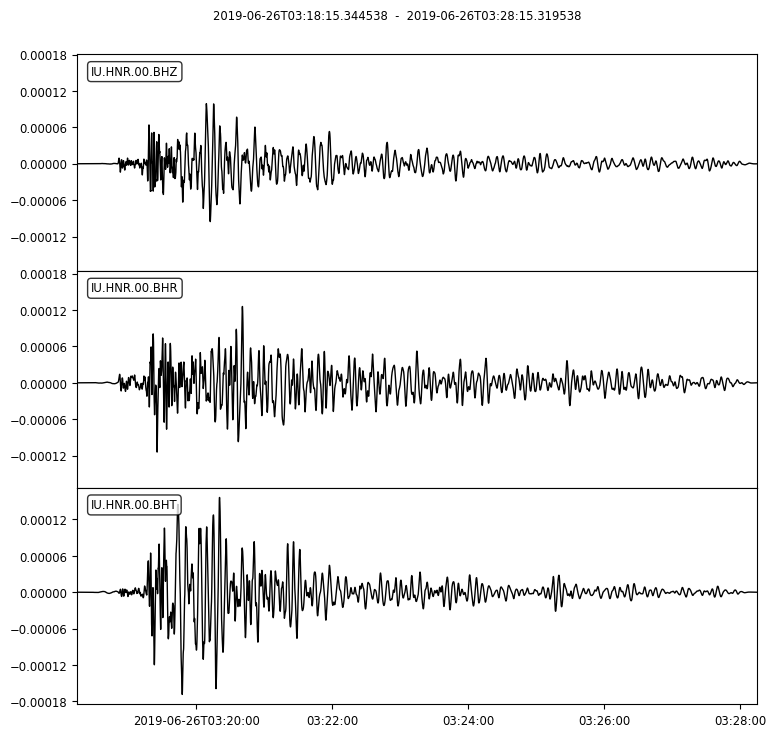

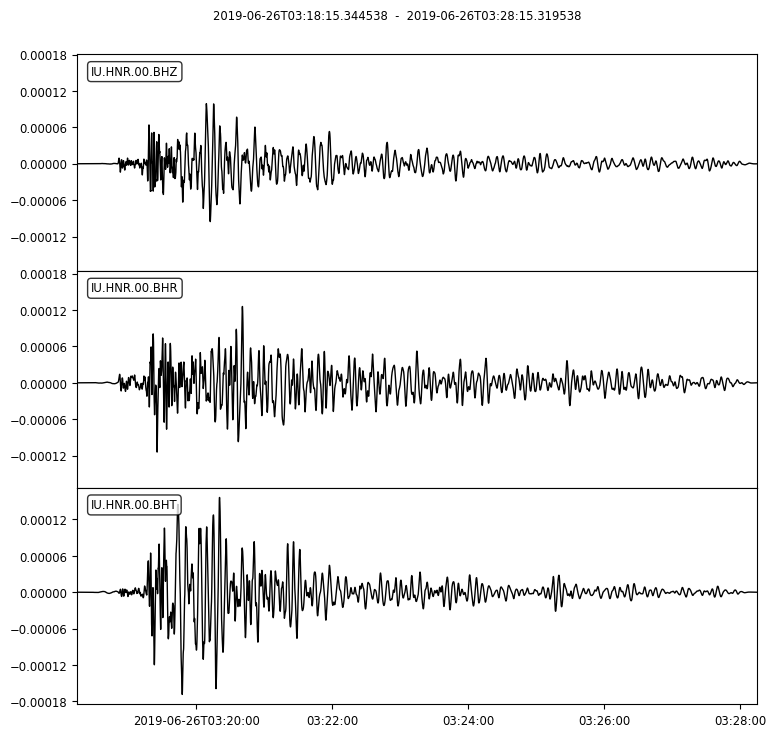

In [33]:
stf.plot()

## 積分與微分

In [ ]:
### 微分
stf.differentiate()

### 積分
stf.integrate()

## 輸出sac header

In [ ]:
### step 1 先將處理好的資料輸出成sac
st.write(sacname, format="sac")

### step 2 : 再讀進sac
st3=read(sacname)

### step 3 :  
### p s time
st3[0].stats.sac.kt1=str(pstimelist[0])
st3[0].stats.sac.t1=float(pstimelist[1])
st3[0].stats.sac.kt2=str(pstimelist[2])
st3[0].stats.sac.t2=float(pstimelist[3])
### eve infor
st3[0].stats.sac.evlo=float(EVLO)
st3[0].stats.sac.evla=float(EVLA)
st3[0].stats.sac.evdp=float(EVDP)
st3[0].stats.sac.mag=float(mag)
### sta infor
st3[0].stats.sac.stlo=float(stlo)
st3[0].stats.sac.stla=float(stla)
### dist infor
st3[0].stats.sac.gcarc=float(gcarc)
st3[0].stats.sac.dist=float(dist)
st3[0].stats.sac.baz=float(baz)
st3[0].stats.sac.az=float(az)
st3.write(sacname, format="sac")

### 7. 數值處理

# 7.1 Fourier transform

Plot the power of the FFT of a signal and inverse FFT back to reconstruct a signal.

## we use the packages from `numpy`: `np.fft.fft()`, `np.fft.fftfreq()` and `np.fft.ifft()`


* https://docs.scipy.org/doc/numpy/reference/routines.fft.html

p.s. you can also use the packages from `scipy`: `scipy.fftpack.fft()`, `scipy.fftpack.fftfreq()` and `scipy.fftpack.ifft()`

#### SciPy - Library of scientific algorithms for Python

The SciPy framework builds on top of the low-level NumPy framework for multidimensional arrays, and provides a large number of higher-level scientific algorithms. Some of the topics that SciPy covers are:

* Fourier Transforms ([scipy.fftpack](http://docs.scipy.org/doc/scipy/reference/fftpack.html))





In [17]:
import numpy as np
H_f = np.fft.fft(stf[0].data)
print(H_f)

[-10652215.00000000     +0.j             96530.04654697 -60848.74972212j
    180559.78430107-240320.52587908j ...,
    -93358.73156379+201021.15044429j    180559.78430107+240320.52587908j
     96530.04654697 +60848.74972213j]


In [18]:
H_freal = H_f.real    # 獲取實數部分
H_fimag = H_f.imag    # 獲取虛數部分
print(H_freal)

[-10652215.             96530.04654697    180559.78430107 ...,
    -93358.73156379    180559.78430107     96530.04654697]


In [27]:
Amp_spectrum = np.abs(H_f)    # 取絕對值
print(len(Amp_spectrum))

24000


In [20]:
npts = stf[0].stats.npts                   # number of samples in the trace
dt = stf[0].stats.delta                    # sample interval
fNy = 1. / (2. * dt)                      # Nyquist frequency
time = np.arange(0, npts) * dt            # time axis for plotting
freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting

In [23]:
# amplitude spectras ; rfft 只看正的部分
Ospec = np.fft.rfft(stf[0].data)

Text(0, 0.5, 'amplitude')

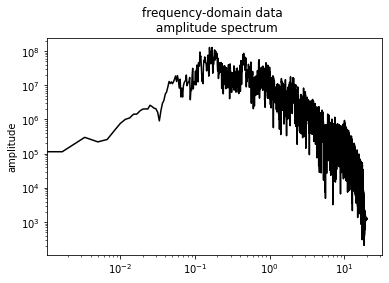

In [30]:
import matplotlib.pyplot as plt 
#plt.plot(freq, abs(Ospec), 'k') ### linear 
plt.loglog(freq,abs(Ospec), 'k') ### loglog sacle
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
#plt.xlim(0,20)

# 7.2 Cross-correlation 

np.correlate(x,y,mode='full')

if x = y >> auto_correlation

In [31]:
x=stf[0].data - stf[0].data.mean()
ccov = np.correlate(x,x, mode='full')

In [37]:
ccor = ccov / (npts * x.std() * x.std())

In [38]:
lags = np.arange(-npts + 1, npts)

Text(0.5, 0, 'lag of y1 relative to y2')

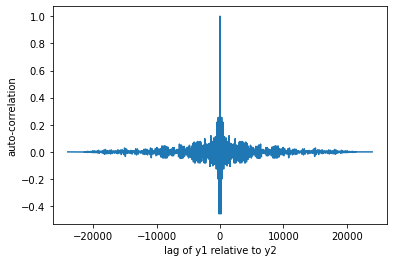

In [40]:
plt.plot(lags, ccor)
plt.ylabel('auto-correlation')
plt.xlabel('lag of y1 relative to y2')

# 7.3 Convolve 

np.convolve(x,y,mode='full')

https://numpy.org/doc/stable/reference/generated/numpy.convolve.html#numpy.convolve